[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vietanhdev/sdc-tutorial/blob/master/notebooks/Lane-Line-Detection.ipynb)

# Build your own self-driving car on simulation - Part 1: Lane line detection

Develop your own self-driving algorithms, from lane line detection, traffic sign, and car control.

**Authors:** [vietanhdev](https://github.com/vietanhdev).


In [ ]:
# Import packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from imutils import paths
import numpy as np
import os
import glob
import cv2
import math
%matplotlib inline


## 1. Download sample images

First, we need to download some sample images to test our algorithm. This dataset includes 10 photos taken from a self driving car simulation which based on [Udacity driving simulator](https://github.com/udacity/self-driving-car-sim). We will develop and test our algorithms on these images before applying them to interatively drive a car. The `wget` command below will help us to download the data file, then the `unzip` command will help us to extract this data file.

In [ ]:
!wget https://github.com/vietanhdev/sdc-tutorial/raw/master/content/images/lane_line_images.zip
!unzip -qo lane_line_images.zip

--2021-12-02 03:21:03--  https://github.com/vietanhdev/sdc-tutorial/raw/master/content/images/lane_line_images.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/vietanhdev/sdc-tutorial/master/content/images/lane_line_images.zip [following]
--2021-12-02 03:21:03--  https://raw.githubusercontent.com/vietanhdev/sdc-tutorial/master/content/images/lane_line_images.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 897846 (877K) [application/zip]
Saving to: ‘lane_line_images.zip’

lane_line_images.zi 100%[===================>] 876.80K  --.-KB/s    in 0.009s  

2021-12-02 03:21:04 (98.4 MB/s) - ‘lan

In [ ]:
n_images = 6
image_names = ["{}.png".format(i) for i in range(1, n_images+1)]

## 2. Show the images

The function `show_images()` is provided to display images on this notebook, it will help us to display multiple images at the same time on the Notebook file. Image rendering on Colab Notebooks is done with the `plt.imshow()` function from the `matplotlib` library.

In [ ]:
def show_images(images, cmap="viridis"):
    column = 3
    row = int(math.ceil(len(images)/column))
    plt.figure(figsize=(20, 10))
    for i, img in enumerate(images):
        plt.subplot(row,column,i+1)
        if cmap != "gray":
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img, cmap=cmap)
        plt.axis('off')

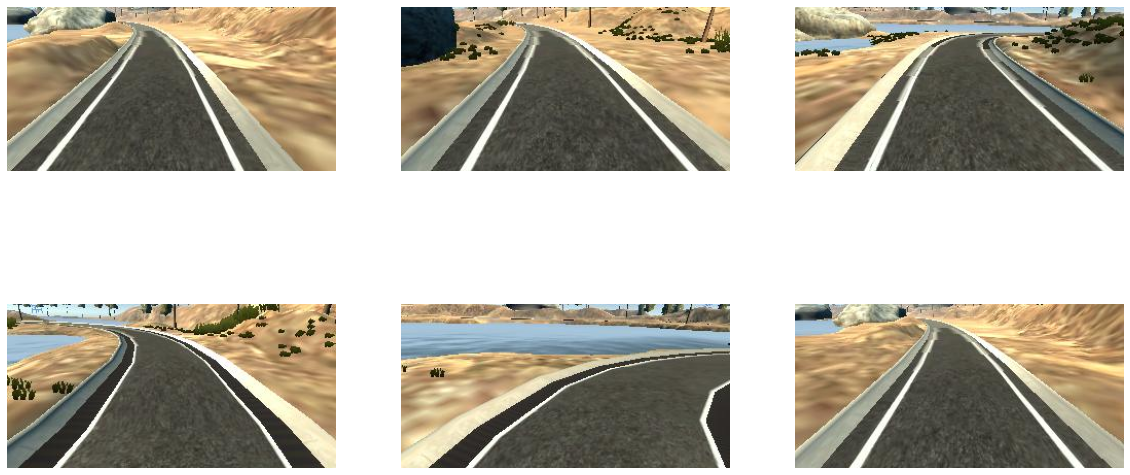

In [ ]:
## Read all images and show
bgr_images = [cv2.imread(name) for name in image_names]
show_images(bgr_images)

## 3. Lane line filtering



Lane line detection is an intelligence feature in many cars today, which allows the vehicle to issue warnings when the driver goes out of lane unintentionally or helps to stay the lane center actively. In this tutorial, we will develop a simple pipeline for lane line detection from images. Our algorithm contains three steps:  convert images to grayscale, remove noise by Gaussian filter and apply Canny edge detector to find lane lines from image images.
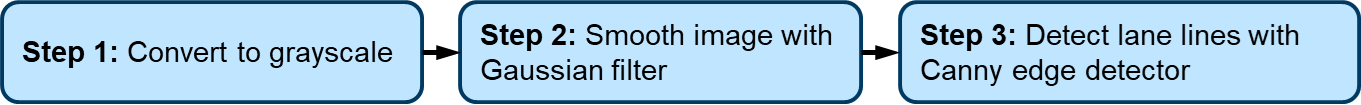





In [ ]:
def find_lane_lines(img):
    """
    Detecting road markings
    This function will take a color image, in BGR color system,
    Returns a filtered image of road markings
    """

    # Convert to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply a Gaussian filter to remove noise
    # You can experiment with other filters here.
    img_gauss = cv2.GaussianBlur(gray, (11, 11), 0)

    # Apply Canny edge detection
    thresh_low = 150
    thresh_high = 200
    img_canny = cv2.Canny(img_gauss, thresh_low, thresh_high)

    # Return image
    return img_canny


Run our algorithm with all demo images

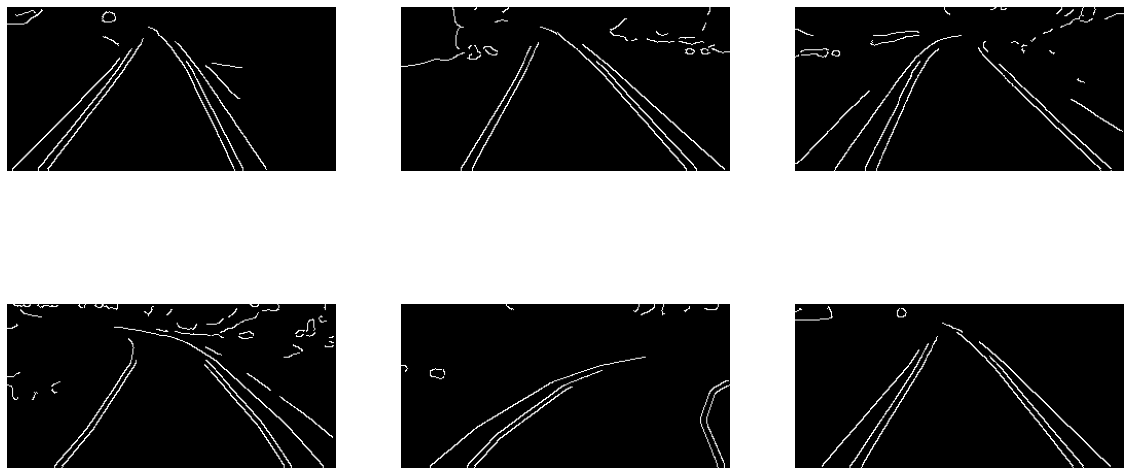

In [ ]:
list_img_lines = []
for img in bgr_images:
    img_lines = find_lane_lines(img)
    list_img_lines.append(img_lines)

# Show the result
show_images(list_img_lines)

## 4. Bird-eye view

Looking at the road from the oblique direction with the road surface is difficult to calculate the turning angle for the vehicle. Therefore, we will change the image’s perspective from the oblique direction to the direction perpendicular to the road surface using bird-view transform. A magic technique in computer vision named perspective transform allows us to find the transformation parameters from four points in the image and corresponding points in the perpendicular plane. We then use cv2.warpPerspective() to apply that transformation to any image.

Read more about perspective transform here:
 https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/.

**Birdview transform**

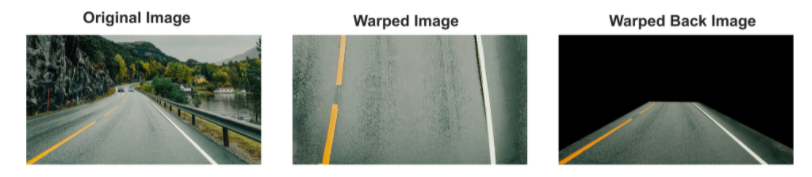

Let's write a function for bird-view transform

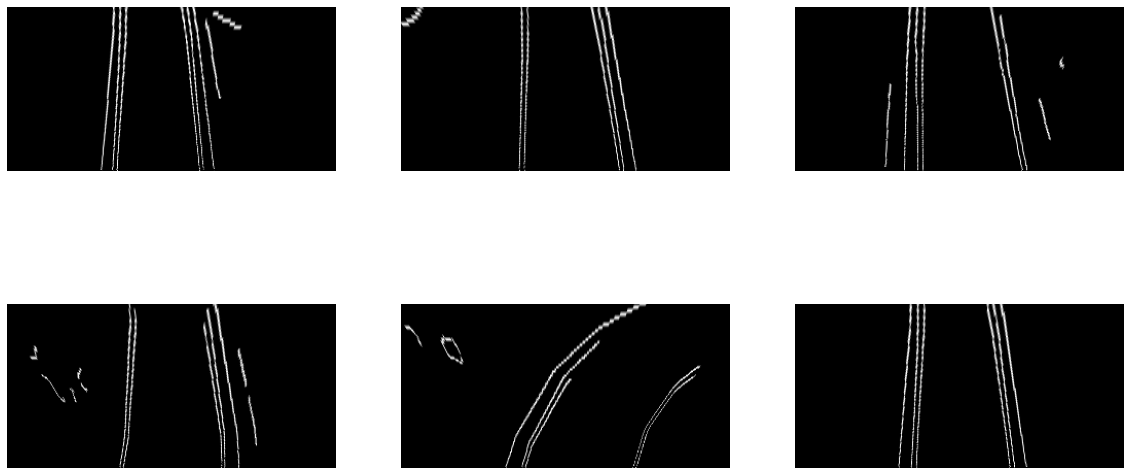

In [ ]:
def birdview_transform(img):
    IMAGE_H = 160
    IMAGE_W = 320
    src = np.float32([[0, IMAGE_H], [320, IMAGE_H], [0, IMAGE_H//3], [IMAGE_W, IMAGE_H//3]])
    dst = np.float32([[90, IMAGE_H], [230, IMAGE_H], [-10, 0], [IMAGE_W+10, 0]])
    M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix
    warped_img = cv2.warpPerspective(img, M, (IMAGE_W, IMAGE_H)) # Image warping
    return warped_img

# Apply bird-view transform with outputs from Canny edge detector
birdview_images = [birdview_transform(img) for img in list_img_lines]
show_images(birdview_images, cmap="gray")

## 5. Find left/right points

After obtaining a bird-view image, a simple method to help determine the vehicle's position relative to the lane is to find two points, one on the left lane line and one on the right lane line. Finally, we consider the position of the midpoint of the vehicle relative to those two points to determine the deviation of the car from the lane and calculate the appropriate steering angle.

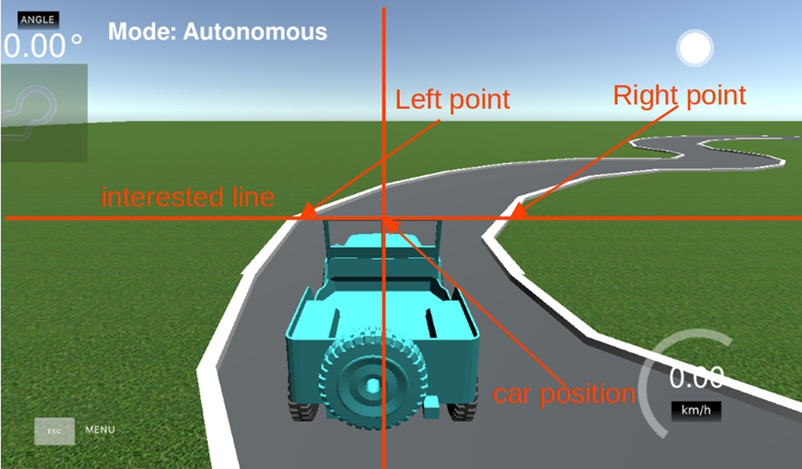

The code below will consider a horizontal line (`interested_lin`e) in the image. From the image’s center position, we traverse the two sides, find the first non-zero value pixels, and consider them as the position of the left and right lines. We predefined the lane `width lane_width = 100`, so we can use this value to find one of the two left/right points when only the other point is visible.



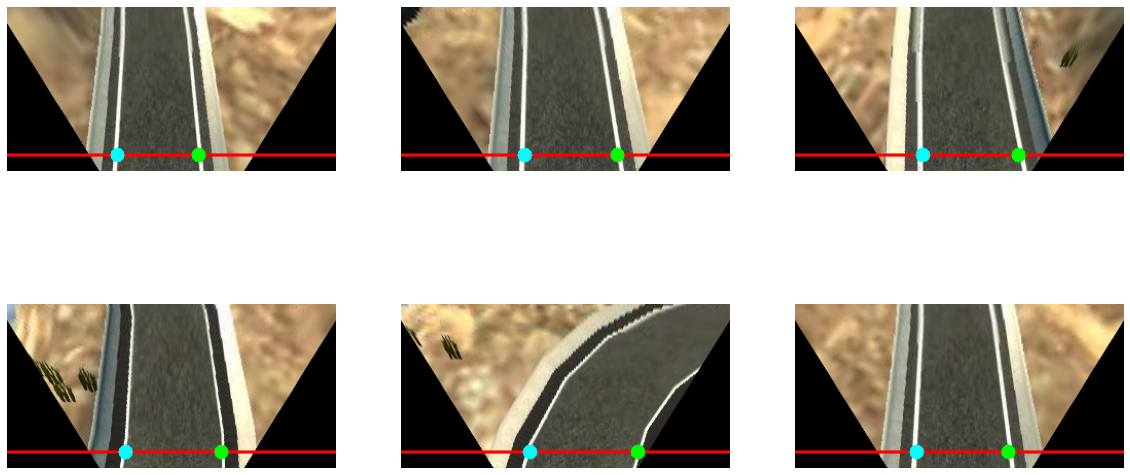

In [ ]:
def find_left_right_points(image, draw=None):
    """Find left and right points of lane
    """

    im_height, im_width = image.shape[:2]

    # Consider the position 70% from the top of the image
    interested_line_y = int(im_height * 0.9)
    if draw is not None:
        cv2.line(draw, (0, interested_line_y),
                 (im_width, interested_line_y), (0, 0, 255), 2)
    interested_line = image[interested_line_y, :]

    # Detect left/right points
    left_point = -1
    right_point = -1
    lane_width = 100
    center = im_width // 2

    # Traverse the two sides, find the first non-zero value pixels, and
    # consider them as the position of the left and right lines
    for x in range(center, 0, -1):
        if interested_line[x] > 0:
            left_point = x
            break
    for x in range(center + 1, im_width):
        if interested_line[x] > 0:
            right_point = x
            break

    # Predict right point when only see the left point
    if left_point != -1 and right_point == -1:
        right_point = left_point + lane_width

    # Predict left point when only see the right point
    if right_point != -1 and left_point == -1:
        left_point = right_point - lane_width

    # Draw two points on the image
    if draw is not None:
        if left_point != -1:
            draw = cv2.circle(
                draw, (left_point, interested_line_y), 7, (255, 255, 0), -1)
        if right_point != -1:
            draw = cv2.circle(
                draw, (right_point, interested_line_y), 7, (0, 255, 0), -1)

    return left_point, right_point

viz_images = []
for i, img in enumerate(birdview_images):
    draw = birdview_transform(bgr_images[i]).copy() # For color visualization
    left_point, right_point = find_left_right_points(img, draw=draw)
    viz_images.append(draw)

show_images(viz_images)

### 6. Calculate control signal

Function `calculate_control_signal()` is used to calculate the speed and steering angle for the car based on the input image. After the `find_land_lines()` step uses Canny to search for road lines, the image will be passed through `birdview_transform()` to perform the birdview transformation, taking the top-down view. Next is the algorithm to find the left / right points of the lane through the function `find_left_right_points()`. From the two points left and right, we can completely calculate the deviation of the vehicle from the road surface (considering the camera is in the center of the vehicle, the center of the image `im_center` is also the center of the vehicle):

In [ ]:
def calculate_control_signal(img, draw=None):
    """Calculate speed and steering angle
    """

    # Find left/right points
    img_lines = find_lane_lines(img)
    img_birdview = birdview_transform(img_lines)
    draw[:, :] = birdview_transform(draw)
    left_point, right_point = find_left_right_points(img_birdview, draw=draw)

    # Calculate speed and steering angle
    # The speed is fixed to 50% of the max speed
    # You can try to calculate speed from turning angle
    throttle = 0.5
    steering_angle = 0
    im_center = img.shape[1] // 2

    if left_point != -1 and right_point != -1:

        # Calculate the deviation
        center_point = (right_point + left_point) // 2
        center_diff =  im_center - center_point

        # Calculate steering angle
        # You can apply some advanced control algorithm here
        # For examples, PID
        steering_angle = - float(center_diff * 0.01)

    return throttle, steering_angle